## Import 

### Official Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import os

from scipy.signal import resample, hilbert, correlate
from tqdm import tqdm
from obspy import UTCDateTime, read

from andbro__store_as_pickle import __store_as_pickle
from pandas import read_pickle

### Own Processing Methods

In [3]:
import sys
sys.path.insert(0, 'submodules')

In [4]:
from EchoPerformance import __echo_performance
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from MakeplotDemodulationQuality import __makeplot_demodulation_quality
from MinimizeResidual import __minimize_residual
from CreateLinearChirp import __create_linear_chirp
from Tapering import __tapering
from InstaFreqHilbert import __insta_freq_hilbert
from Normalize import __normalize
from WriteToMseed import __write_to_mseed
from LoadMseed import __load_mseed
from Modulation import __modulation
from QuerrySeismoData import __querry_seismo_data


In [5]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Own Plotting Methods

In [6]:
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal

## Configurations

In [7]:

oversampling = 1

T = 1600 #seconds

sps = 5000 #samples

sgnc = 550 #Hz

f_lower, f_upper = 0.01, 0.05 # 0.05

modulation_index = 10.0
# modulation_index = 0.1

# frequency_deviation = 0.5
# modulation_index = frequency_deviation/f_upper

modulation_scheme = 3


taper_type = "window"
taper_percent = 0.02


syn_signal = 'real_trace_local'  ## 'chirp' or 'synthetic_trace' or 'real_trace'

path_to_figs = data_path+"SagnacProcessing/figures/"

## Get Synthetic Signal

#### Random Trace Signal or Chirp

In [8]:
sps = sps * oversampling

In [9]:
if syn_signal == 'synthetic_trace':

    ##_______________________________________________________________
    ## call synthetic event generator (version2)

    ## load trace or create and write one if not yet existing

    # iname=f"data/SYN_T{int(T)}_fs{int(sps)}_f{f_lower}-{f_upper}.mseed"
    # modeltrace, time_modeltrace = __load_mseed(iname, T, sps, f_lower, f_upper)

    modeltrace, time_modeltrace =__create_synthetic_event_v2(T,
                                                             sps,
                                                             f_lower,
                                                             f_upper,
                                                             noise=False,
                                                             padding=None,
                                                             noise_level=None,
                                                             )

#     modeltrace = __tapering(modeltrace, taper_type, taper_percent)

     ## normalize trace to avoid issues with demodulation
    modeltrace = __normalize(modeltrace)

## ______________________________________________
elif syn_signal == 'chirp':
    ##_______________________________________________________________
    ## make chirp signal

    modeltrace, time_modeltrace = __create_linear_chirp(T,
                                                        sps,
                                                        f_lower,
                                                        f_upper,
                                                       )

## ______________________________________________
elif syn_signal == 'real_trace':

    ## set starttime and endtime
    tbeg = UTCDateTime(2020, 10, 30, 12, 0)
    tend = tbeg + T

    ## get stream data
    RLAS, RLAS_inv = __querry_seismo_data("BW.RLAS..HJZ",
                                          tbeg,
                                          tend,
                                          restitute=True,
                                          )

    RLAS[0].resample(sampling_rate=sps)

    RLAS[0].filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)

    time_modeltrace = np.arange(0, T+1/sps, 1/sps)
    modeltrace = RLAS[0].data[0:time_modeltrace.size]

    modeltrace = __normalize(modeltrace)

elif syn_signal == 'real_trace_local':

    ## set starttime and endtime
    tbeg = UTCDateTime(2023, 9, 8, 22, 15)
    tend = tbeg + T

    ## get stream data
    RLAS = read(root_path+"/Downloads/mseed/ROMY_BJU_2023-09-08.mseed", starttime=tbeg, endtime=tend)

    RLAS[0].resample(sampling_rate=sps)

    RLAS[0].filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)

    time_modeltrace = np.arange(0, T+1/sps, 1/sps)
    modeltrace = RLAS[0].data[0:time_modeltrace.size]

    modeltrace = __normalize(modeltrace)

## ______________________________________________*
else:
    print("Wrong choise!")


Apply taper to avoid edge effects (not really necessary)


In [10]:
modeltrace = __tapering(modeltrace, taper_type='hann', percent=0.2)

Display the synthetic signal trace, which is modulated onto the carrier.

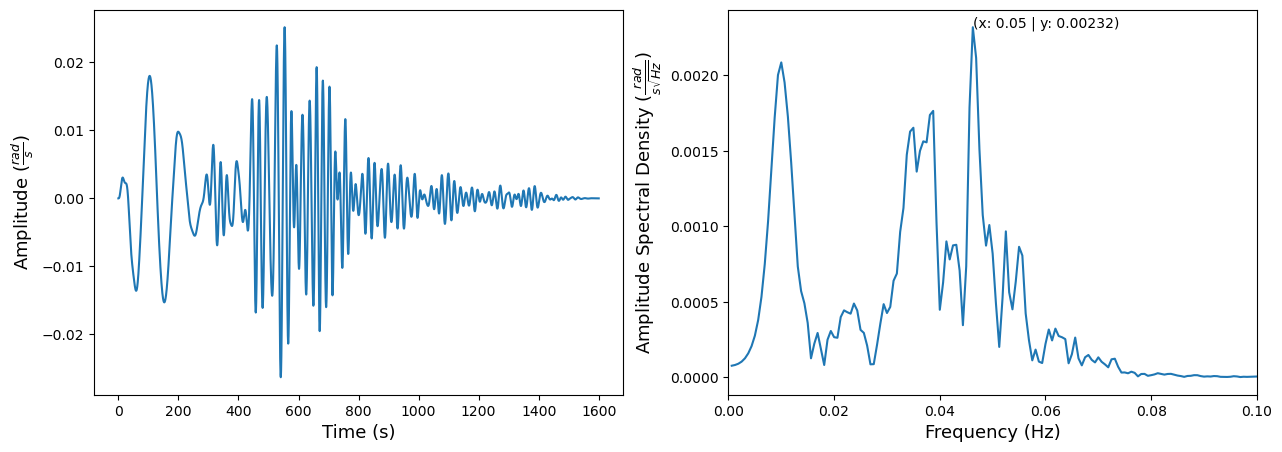

In [11]:
fig = __makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=2*f_upper);
del fig

In [12]:
# fig.savefig(path_to_figs+f"SP_{syn_signal}_{f_lower}_{f_upper}_modeltrace.png", format="png", dpi=150, bbox_inches='tight')

Possibility to write modeltrace and time axis to a stream as .mseed to load it in an other script. Load a trace enhances comparability since it is not randomly gereated each time.

In [ ]:
# oname = f'data/syn_T{int(T)}_fs{int(sps)}_f{f_lower}-{f_upper}.mseed'

# __write_to_mseed(modeltrace, time_modeltrace, oname, sps)

# Modulation

In [13]:
# timeline, synthetic_signal = __modulation(modeltrace, time_modeltrace, T, sps, mod_index=modulation_index)


synthetic_signal, timeline = __modulation(modeltrace,
                                          time_modeltrace,
                                          sgnc,
                                          T,
                                          sps,
                                          modulation_index,
                                          modulation_scheme,
                                         )



Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 3.6 sec


In [14]:
gc.collect()

10902

### Noise

0   White Phase Modulation (WPM)

1  Flicker Phase Modulation (FPM)

2  White Frequency Modulation (WFM)

3  Flicker Frequency Modulation (FFM)

4  Random Walk Frequency Modulation (RWFM)

In [ ]:
import allantools as at


In [ ]:
# noise = at.noise_kasdin.Noise(nr=NN, qd=1e-20, b=-4)
# noise.generateNoise()
# xnoise = noise.time_series
# xnoise = xnoise / max(abs(xnoise))

# __store_as_pickle(xnoise, "./data/noise-4.pkl")

# del noise, xnoise

In [ ]:
a_max_percent = 1 # percent

set_noise = "noise4"

noise = read_pickle(f"./data/{set_noise}.pkl")

noise *= a_max_percent/100

In [ ]:
plt.plot(noise)

In [ ]:
fig = __makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=40, t2=40.01);
# fig = __makeplot_trace_and_spectrum(synthetic_signal, timeline, fmax=2500);
del fig

In [ ]:
synthetic_signal += noise

In [ ]:
__store_as_pickle(synthetic_signal, f"./data/syn_real_{set_noise}.pkl")

In [ ]:
fig = __makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=40, t2=40.01);
del fig

In [15]:
sig0 = read(root_path+"/Downloads/mseed/DROMY_FJU_2023-09-08.mseed", starttime=tbeg, endtime=tend)
sig = sig0[0].data / max(abs(sig0[0].data))
del sig0

In [16]:
from submodules.get_fft import __get_fft

In [17]:
signal = read_pickle(f"./data/syn_real.pkl")

noise0 = read_pickle(f"./data/syn_real_noise0.pkl")
noise1 = read_pickle(f"./data/syn_real_noise1.pkl")
# noise2 = read_pickle(f"./data/syn_real_noise2.pkl")
# noise3 = read_pickle(f"./data/syn_real_noise3.pkl")
noise4 = read_pickle(f"./data/syn_real_noise4.pkl")


In [18]:
specy, fy, py = __get_fft(sig, 1/sps, window="hann")

specx, fx, px = __get_fft(signal, 1/sps, window="hann")

spec0, f0, p0 = __get_fft(noise0, 1/sps, window="hann")
spec1, f1, p1 = __get_fft(noise1, 1/sps, window="hann")
# spec2, f2, p2 = __get_fft(noise2, 1/sps, window="hann")
# spec3, f3, p3 = __get_fft(noise3, 1/sps, window="hann")
spec4, f4, p4 = __get_fft(noise4, 1/sps, window="hann")


In [1]:
plt.loglog(fy, specy, "k")
plt.loglog(fx, specx)

plt.loglog(f0, spec0)
plt.loglog(f1, spec1)
# plt.loglog(f2, spec2)
# plt.loglog(f3, spec3)
plt.loglog(f4, spec4)


NameError: name 'plt' is not defined

NameError: name 'fy' is not defined

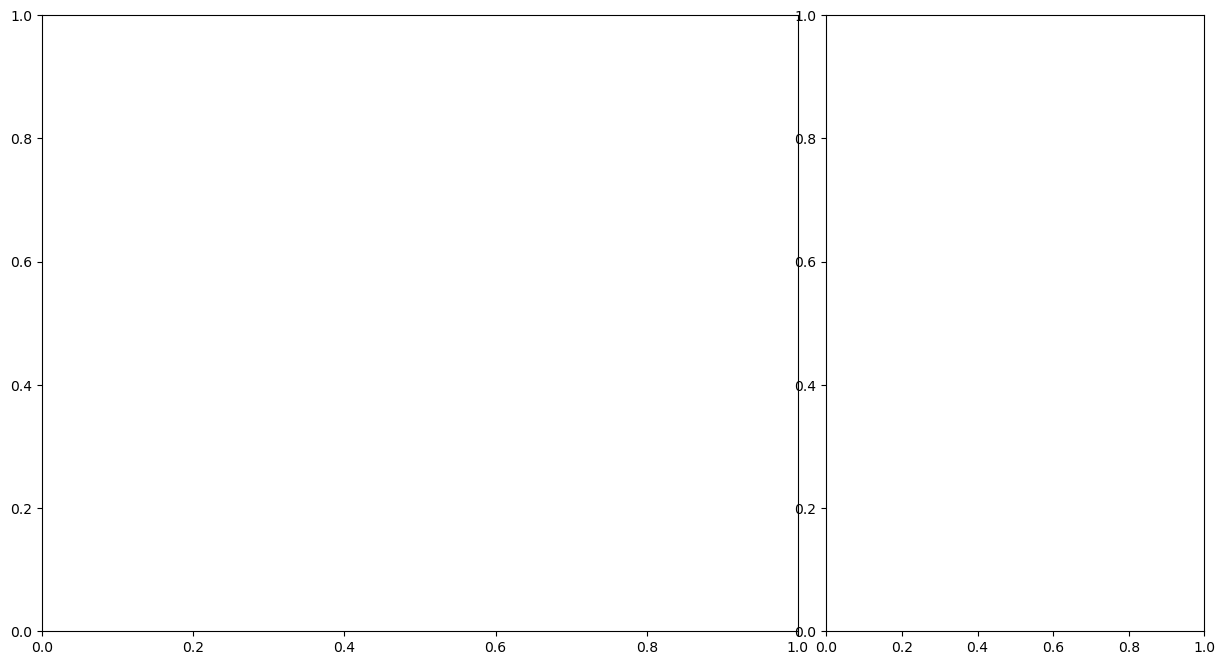

In [1]:
def __makeplot_overview_with_zoomin(plot_dB=True):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    font = 14

    fig = plt.figure(figsize=(15, 8))

    plt.subplots_adjust(wspace=0.05)

    gs = GridSpec(1, 2, width_ratios=[2, 1])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    ax1.loglog(fy, specy, "k")
    ax1.loglog(fx, specx)

    ax1.loglog(f0, spec0)
    ax1.loglog(f1, spec1)
    ax1.loglog(f2, spec2)
    ax1.loglog(f3, spec3)
    ax1.loglog(f3, spec4)

    ax1.grid(alpha=0.2, which="both")
    ax1.set_xlabel("Frequency (Hz)", fontsize=font)
    # ax1.set_ylabel(f"PSD (dB rel. to ({max_max_db} $V^2$/Hz))", fontsize=font)
    ax1.legend(loc="upper center", fontsize=font-1, ncol=3)
    ax1.tick_params(labelsize=font-2)


    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    ax2.grid(alpha=0.2, which="both")
    ax2.tick_params(labelsize=font-2)
    ax2.set_yticklabels([])

    # ax2.set_xlim(config['f_lower_zoomin'], config['f_upper_zoomin'])

    # for ax in [ax1, ax2]:
    #     if plot_dB:
    #         ax.set_ylim(-150, max_max_db)
    #     else:
    #         ax.set_ylim(bottom=1e-15)

    ax1.text(.01, .99, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.01, .99, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    # time_str = f"{str(stx[0].stats.starttime.time).split('.')[0]} - {str(stx[0].stats.endtime.time).split('.')[0]} UTC"
    # ax1.set_title(f"{stx[0].stats.starttime.date} {time_str}")

    plt.show();
    return fig

__makeplot_overview_with_zoomin(plot_dB=True)

### Taper

In [ ]:
# synthetic_signal = __tapering(synthetic_signal, taper_type='window', percent=0.2)

In [ ]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=40, t2=40.01);

In [ ]:
# fig.savefig(path_to_figs+f"SP_{syn_signal}_{f_lower}_{f_upper}_modulated.png", format="png", dpi=150, bbox_inches='tight')

In [ ]:
# __makeplot_modulated_signal(synthetic_signal, timeline);

### Downsample

The modulation has been performed with an oversampling factor to avoid erros. Now the result is resampled mimicing the real sampling of the analog signal.

In [ ]:
# sps /= oversampling


# real_time = np.arange(0,T+1/sps,1/sps)

# tmp1 = np.interp(real_time, time_modeltrace, modeltrace)
# tmp2 = np.interp(real_time, modeltrace, time_modeltrace)
# tmp3 = np.interp(real_time, timeline, synthetic_signal)

# timeline = real_time

# modeltrace = tmp1
# time_modeltrace = tmp2
# synthetic_signal = tmp3

In [ ]:
modeltrace = modeltrace[::oversampling]
time_modeltrace = time_modeltrace[::oversampling]

synthetic_signal = synthetic_signal[::oversampling]
timeline = timeline[::oversampling]

sps = 1/(timeline[1]-timeline[0])

In [ ]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=10, t2=10.1);

# Demodulation

In order to evaluate the demodulated signal it is compared to the kown synthetic signalthe. For this, the median is substracted and 1% of the edges are cut off. Then both, the orignal and the retrieved signal are normalized and a cross-correlation calculated.

In [ ]:

# time_demod_signal, demod_signal = __insta_freq_hilbert(synthetic_signal, timeline, sps, sgnc)


In [ ]:
def __hibert_filter(sig_in, time_in, fs):

    '''
    estimating the instantaneous frequency by using the formula of Jo

    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''

    ## calulcate hilbert transform
    hil0 = hilbert(sig_in)

    ## extract imaginary part of hilbert transform 
    hil = np.imag(hil0)


    ## calculate derivatives 
    d_hil = np.gradient(hil, edge_order=1)
    d_sig = np.gradient(sig_in, edge_order=1)

    delta_f_full = (sig_in * d_hil - d_sig * hil) / (2*np.pi*np.sqrt(sig_in**2 + hil**2))
# #     delta_f_full = (sig_in[1:]*np.diff(hil) - np.diff(sig_in) * hil[1:]) / (2*np.pi*np.sqrt(sig_in[1:]**2 + hil[1:]**2))

    ## extract real part
    delta_f = np.real(delta_f_full)


    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    sum0, idx = 0, []
    for k, x in enumerate(delta_f):
        if np.isnan(x):
            sum0 += 1
            idx.append(k)
    print(sum0, " nan found")

    for l in idx:
        delta_f[l] = 0


    ## _______________________________________________________________________________

#    return time_in[1:], delta_f
    return time_in, delta_f


In [ ]:

time_demod_signal, demod_signal = __hibert_filter(synthetic_signal, timeline, sps)


### Remove Offset

In [ ]:
print(f"theo. Sagnac Frequencs: {sgnc} Hz")
print(f"Median Demodulated Signal: {np.median(demod_signal)}")

# demod_signal = demod_signal - sgnc
demod_signal = demod_signal - np.median(demod_signal)

### Remove Edges

In [ ]:
cutoff = int(0.01*demod_signal.size)

cut1 = np.array([i for i in demod_signal[:cutoff]])
cut2 = np.array([i for i in demod_signal[-cutoff:]])
demod_signal[:cutoff] = 0
demod_signal[-cutoff:] = 0

### Normalize

In [ ]:
demod_signal_norm = __normalize(demod_signal)
modeltrace_norm = __normalize(modeltrace)

# demod_signal_norm = __tapering(demod_signal_norm, 'flanks', percent=0.1)

### Cross-Correlation

In [ ]:
cross_corr = correlate(demod_signal, modeltrace, mode='same')

cross_corr_lags = np.arange(-cross_corr.size//2+1,cross_corr.size//2+1,1)

### Final Plotting

In [ ]:
plt.plot(timeline, modeltrace_norm)
plt.plot(time_demod_signal, demod_signal_norm)

In [ ]:
def __makeplot_residual(arr1, arr2, t1, t2, pcut=0.05):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec

    def __variance_reduction(arr1, arr2):
        from numpy import var
        sig1 = var(arr1)
        sig2 = var(arr2)
        return round( (sig1 - sig2) / sig1 * 100, 2)

    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*1e2, 2)
        return pmax

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)

    def __cut(arr, pcut):
        N = len(arr)
        nx = int(N*pcut)
        arr[:nx] = np.nan
        arr[-nx:] = np.nan
        return arr

    tscale, tunit = 1, "s"


    Ncol, Nrow = 1, 3

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])

    ax1.plot(t1*tscale, arr1, color="black", alpha=0.2)
    ax1.plot(t2*tscale, arr2, color="tab:red", alpha=0.2)

    arr1x = __cut(arr1, pcut)
    arr2x = __cut(arr2, pcut)

    ax1.plot(t1*tscale, arr1x, color="black", label=f"modeltrace")
    ax1.plot(t2*tscale, arr2x, color="tab:red", label=f"hilbert demodulated")

    ax2.plot(t1*tscale, ( arr1x-arr2x ), color="grey", lw=lw)

    ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc=1, ncol=3)

    ax1.set_ylabel(f"$\Omega$ (rad/s)", fontsize=font)
    ax2.set_ylabel(f"residual\n(rad/s)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit})", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    arr1xn = np.nan_to_num(arr1x, 0)
    arr2xn = np.nan_to_num(arr2x, 0)

    R = __variance_reduction(arr1xn, arr1xn - arr2xn)

    txt = f"RMSE = {__rmse(arr1xn, arr2xn)}, max = {__get_residual_percent(arr1xn, arr2xn)}%, R = {R}%"

    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    ax1.set_title(f" f = {f_lower} - {f_upper} Hz")

    # ax1.grid(ls=":", zorder=0)
    # ax2.grid(ls=":", zorder=0)

    gc.collect()

    plt.plot();
    return fig

fig = __makeplot_residual(modeltrace_norm, demod_signal_norm, timeline, time_demod_signal, 0.01)

fig.savefig(path_to_figs+f"SP_{syn_signal}_{f_lower}_{f_upper}.png", format="png", dpi=150, bbox_inches='tight')

del fig

gc.collect()

In [ ]:
import numpy as np

dt = 0.1
f = 0.1
t = np.arange(0, 100, dt)
y = np.sin(2*np.pi* f * t)
y2 = np.cos(2*np.pi* f * t)

# dy1 = third_order_derive(y)
dy2 = np.diff(y, n=1)/(2*np.pi*f)/dt
# dy3 = np.diff(y, n=2)/dt/dt
dy3 = np.gradient(y, edge_order=1)/(2*np.pi*f)/dt

plt.figure(figsize=(15,5))

plt.scatter(t,y,s=1, color='blue')
plt.plot(t, y2, color='orange')

plt.scatter(t[:-1], dy2, s=2, color="green")
plt.scatter(t, dy3, s=2, color="red")


plt.axhline(0, color='k')
plt.xlim(0,10)

In [ ]:

# fig = __makeplot_demodulation_quality(timeline,
#                                       modeltrace_norm,
#                                       time_demod_signal,
#                                       demod_signal_norm,
#                                       cross_corr,
#                                       cross_corr_lags,
#                                       sps,
#                                      );
